# Notebook 8: Quantum Machine Learning (QML) Models

**Purpose**: Train and evaluate QML models with proper epoch configuration.

**Epoch Config (per Master Prompt)**:
- All QML models: `max_epochs=30-50`, `patience=5`
- Prefer early convergence to avoid barren plateaus

**Models**:
1. VQC (max=30, patience=5)
2. Hybrid QNN (max=30, patience=5)
3. QSVM (kernel-based, no epochs)
4. Quantum Autoencoder (max=30, patience=5)
5. QGAN (max=30, patience=5)

---

In [1]:
import sys
sys.path.append('..')

import numpy as np
import pandas as pd
import json
import time
from pathlib import Path
import matplotlib.pyplot as plt

import pennylane as qml
from pennylane import numpy as pnp
from pennylane.templates import AngleEmbedding, StronglyEntanglingLayers

import torch
import torch.nn as nn
import torch.optim as optim

from sklearn.svm import SVC
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    roc_auc_score, roc_curve, confusion_matrix
)
from sklearn.model_selection import train_test_split
import warnings
warnings.filterwarnings('ignore')

RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
pnp.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)

BASE_DIR = Path('.').resolve().parent
FEATURES_DIR = BASE_DIR / 'data' / 'features'
RESULTS_DIR = BASE_DIR / 'results'
MODELS_DIR = BASE_DIR / 'models'
FIGURES_DIR = BASE_DIR / 'figures'

TARGET_COLUMN = 'Class'

print(f"PennyLane version: {qml.__version__}")

PennyLane version: 0.43.1


In [2]:
# Epoch Configuration (per Master Prompt)
EPOCH_CONFIG = {
    'VQC': {'max_epochs': 30, 'patience': 5, 'expected': '10-20'},
    'Hybrid_QNN': {'max_epochs': 30, 'patience': 5, 'expected': '10-20'},
    'Quantum_Autoencoder': {'max_epochs': 30, 'patience': 5, 'expected': '10-20'},
    'QGAN': {'max_epochs': 30, 'patience': 5, 'expected': '10-20'},
    'QSVM': {'max_epochs': None, 'patience': None, 'expected': 'N/A (kernel)'}
}

def safe_normalize(arr):
    arr = np.asarray(arr, dtype=float)
    min_val, max_val = arr.min(), arr.max()
    if max_val - min_val < 1e-10:
        return np.full_like(arr, 0.5)
    return (arr - min_val) / (max_val - min_val)

class EarlyStoppingQML:
    """Simple early stopping for QML (no model weights to save)."""
    def __init__(self, patience=5):
        self.patience = patience
        self.counter = 0
        self.best_loss = None
        self.early_stop = False
        self.stopped_epoch = 0
    
    def __call__(self, loss, epoch):
        if self.best_loss is None or loss < self.best_loss * 0.999:
            self.best_loss = loss
            self.counter = 0
        else:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True
                self.stopped_epoch = epoch
        return self.early_stop

print("QML Epoch Configuration:")
for model, cfg in EPOCH_CONFIG.items():
    print(f"  {model}: max={cfg['max_epochs']}, patience={cfg['patience']}")

QML Epoch Configuration:
  VQC: max=30, patience=5
  Hybrid_QNN: max=30, patience=5
  Quantum_Autoencoder: max=30, patience=5
  QGAN: max=30, patience=5
  QSVM: max=None, patience=None


## 1. Load Data

In [3]:
train_df = pd.read_csv(FEATURES_DIR / 'pca_train.csv')
test_df = pd.read_csv(FEATURES_DIR / 'pca_test.csv')

X_train_full = train_df.drop(columns=[TARGET_COLUMN]).values.astype(np.float64)
y_train_full = train_df[TARGET_COLUMN].values.astype(np.int32)

X_test_full = test_df.drop(columns=[TARGET_COLUMN]).values.astype(np.float64)
y_test = test_df[TARGET_COLUMN].values.astype(np.int32)

print(f"Training: {X_train_full.shape}, Test: {X_test_full.shape}")

Training: (1600, 10), Test: (400, 10)


In [4]:
N_QUBITS = 4
N_SHOTS = 1024

# Select first N_QUBITS features
X_train = X_train_full[:, :N_QUBITS]
X_test = X_test_full[:, :N_QUBITS]

# Scale to [0, 2π] for angle encoding
X_train_scaled = (X_train - X_train.min()) / (X_train.max() - X_train.min() + 1e-8) * 2 * np.pi
X_test_scaled = (X_test - X_test.min()) / (X_test.max() - X_test.min() + 1e-8) * 2 * np.pi

print(f"QML features: {N_QUBITS}, Qubits: {N_QUBITS}")

QML features: 4, Qubits: 4


In [5]:
# Subsample for QML (computationally expensive)
MAX_TRAIN = 200
MAX_TEST = 100

if len(X_train_full) > MAX_TRAIN:
    X_train_qml, X_val_qml, y_train_qml, y_val_qml = train_test_split(
        X_train_scaled, y_train_full, train_size=int(MAX_TRAIN*0.8), test_size=int(MAX_TRAIN*0.2),
        stratify=y_train_full, random_state=RANDOM_SEED
    )
else:
    X_train_qml, X_val_qml, y_train_qml, y_val_qml = train_test_split(
        X_train_scaled, y_train_full, test_size=0.2, stratify=y_train_full, random_state=RANDOM_SEED
    )

if len(X_test_full) > MAX_TEST:
    X_test_qml, _, y_test_qml, _ = train_test_split(
        X_test_scaled, y_test, train_size=MAX_TEST, stratify=y_test, random_state=RANDOM_SEED
    )
else:
    X_test_qml, y_test_qml = X_test_scaled, y_test

print(f"QML Train: {len(X_train_qml)}, Val: {len(X_val_qml)}, Test: {len(X_test_qml)}")

QML Train: 160, Val: 40, Test: 100


In [6]:
dev = qml.device('default.qubit', wires=N_QUBITS)
print(f"Device: {dev.name}")

def compute_metrics(y_true, y_pred, y_prob=None):
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred, labels=[0, 1]).ravel()
    metrics = {
        'accuracy': accuracy_score(y_true, y_pred),
        'precision': precision_score(y_true, y_pred, zero_division=0),
        'recall': recall_score(y_true, y_pred, zero_division=0),
        'f1_score': f1_score(y_true, y_pred, zero_division=0),
        'fpr': fp / (fp + tn) if (fp + tn) > 0 else 0,
        'tpr': tp / (tp + fn) if (tp + fn) > 0 else 0,
    }
    if y_prob is not None and not np.any(np.isnan(y_prob)):
        try:
            metrics['roc_auc'] = roc_auc_score(y_true, y_prob)
        except:
            metrics['roc_auc'] = 0.5
    else:
        metrics['roc_auc'] = 0.5
    return metrics

Device: default.qubit


In [7]:
all_metrics = []
all_histories = {}
all_probabilities = {}
epoch_metadata = {}

## 2. VQC with Early Stopping

In [8]:
print("Training VQC...")
cfg = EPOCH_CONFIG['VQC']
n_layers = 2

@qml.qnode(dev)
def vqc_circuit(weights, x):
    AngleEmbedding(x, wires=range(N_QUBITS))
    StronglyEntanglingLayers(weights, wires=range(N_QUBITS))
    return qml.expval(qml.PauliZ(0))

weight_shape = StronglyEntanglingLayers.shape(n_layers=n_layers, n_wires=N_QUBITS)
weights_vqc = pnp.random.randn(*weight_shape, requires_grad=True) * 0.1

def vqc_cost(weights, X, y):
    predictions = pnp.array([vqc_circuit(weights, x) for x in X])
    predictions = (predictions + 1) / 2  # Map to [0,1]
    return pnp.mean((predictions - y) ** 2)

opt = qml.GradientDescentOptimizer(stepsize=0.1)
early_stop = EarlyStoppingQML(patience=cfg['patience'])

train_losses, val_losses = [], []
start_time = time.time()

for epoch in range(cfg['max_epochs']):
    weights_vqc, cost = opt.step_and_cost(lambda w: vqc_cost(w, X_train_qml, y_train_qml), weights_vqc)
    train_losses.append(float(cost))
    
    # Validation
    val_cost = float(vqc_cost(weights_vqc, X_val_qml, y_val_qml))
    val_losses.append(val_cost)
    
    if (epoch + 1) % 10 == 0:
        print(f"  Epoch {epoch+1}/{cfg['max_epochs']}, Train: {cost:.4f}, Val: {val_cost:.4f}")
    
    if early_stop(val_cost, epoch + 1):
        print(f"  Early stopping at epoch {epoch+1}")
        break

train_time = time.time() - start_time
stopped_epoch = early_stop.stopped_epoch if early_stop.early_stop else epoch + 1

# Evaluate
y_prob_vqc = np.array([(float(vqc_circuit(weights_vqc, x)) + 1) / 2 for x in X_test_qml])
y_pred_vqc = (y_prob_vqc > 0.5).astype(int)

metrics = compute_metrics(y_test_qml, y_pred_vqc, y_prob_vqc)
metrics.update({'model': 'VQC', 'n_qubits': N_QUBITS, 'circuit_depth': n_layers,
                'train_time': train_time, 'stopped_epoch': stopped_epoch})
all_metrics.append(metrics)
all_histories['VQC'] = {'train': train_losses, 'val': val_losses}
all_probabilities['VQC'] = y_prob_vqc
epoch_metadata['VQC'] = {'max_epochs': cfg['max_epochs'], 'patience': cfg['patience'], 'stopped_epoch': stopped_epoch}
print(f"  F1: {metrics['f1_score']:.4f}, Stopped: {stopped_epoch}/{cfg['max_epochs']}")

Training VQC...
  Epoch 10/30, Train: 0.1657, Val: 0.1701
  Epoch 20/30, Train: 0.1650, Val: 0.1695
  Epoch 30/30, Train: 0.1644, Val: 0.1689
  F1: 0.0952, Stopped: 30/30


## 3. Hybrid QNN with Early Stopping

In [9]:
print("\nTraining Hybrid QNN...")
cfg = EPOCH_CONFIG['Hybrid_QNN']

@qml.qnode(dev, interface='torch')
def hybrid_qnn_circuit(inputs, weights):
    AngleEmbedding(inputs, wires=range(N_QUBITS))
    StronglyEntanglingLayers(weights, wires=range(N_QUBITS))
    return [qml.expval(qml.PauliZ(i)) for i in range(N_QUBITS)]

class HybridQNN(nn.Module):
    def __init__(self, n_qubits, n_layers=2):
        super().__init__()
        weight_shape = StronglyEntanglingLayers.shape(n_layers=n_layers, n_wires=n_qubits)
        self.q_weights = nn.Parameter(torch.randn(*weight_shape) * 0.1)
        self.post_net = nn.Sequential(
            nn.Linear(n_qubits, 8), nn.ReLU(), nn.Linear(8, 1), nn.Sigmoid()
        )
    
    def forward(self, x):
        q_out = hybrid_qnn_circuit(x, self.q_weights)
        q_out = torch.stack(q_out, dim=-1).float()  # Convert Double to Float
        return self.post_net(q_out)

model = HybridQNN(N_QUBITS)
optimizer = optim.Adam(model.parameters(), lr=0.01)
criterion = nn.BCELoss()

X_train_t = torch.tensor(X_train_qml, dtype=torch.float32)
y_train_t = torch.tensor(y_train_qml, dtype=torch.float32)
X_val_t = torch.tensor(X_val_qml, dtype=torch.float32)
y_val_t = torch.tensor(y_val_qml, dtype=torch.float32)

early_stop = EarlyStoppingQML(patience=cfg['patience'])
train_losses, val_losses = [], []
start_time = time.time()

for epoch in range(cfg['max_epochs']):
    model.train()
    epoch_loss = 0
    for i in range(len(X_train_t)):
        optimizer.zero_grad()
        output = model(X_train_t[i]).squeeze()
        loss = criterion(output, y_train_t[i])
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
    train_losses.append(epoch_loss / len(X_train_t))
    
    model.eval()
    with torch.no_grad():
        val_loss = sum(criterion(model(X_val_t[i]).squeeze(), y_val_t[i]).item() for i in range(len(X_val_t)))
    val_losses.append(val_loss / len(X_val_t))
    
    if (epoch + 1) % 10 == 0:
        print(f"  Epoch {epoch+1}/{cfg['max_epochs']}, Train: {train_losses[-1]:.4f}, Val: {val_losses[-1]:.4f}")
    
    if early_stop(val_losses[-1], epoch + 1):
        print(f"  Early stopping at epoch {epoch+1}")
        break

train_time = time.time() - start_time
stopped_epoch = early_stop.stopped_epoch if early_stop.early_stop else epoch + 1

model.eval()
X_test_t = torch.tensor(X_test_qml, dtype=torch.float32)
with torch.no_grad():
    y_prob_hqnn = np.array([model(x).item() for x in X_test_t])
y_pred_hqnn = (y_prob_hqnn > 0.5).astype(int)

metrics = compute_metrics(y_test_qml, y_pred_hqnn, y_prob_hqnn)
metrics.update({'model': 'Hybrid_QNN', 'n_qubits': N_QUBITS, 'circuit_depth': 2,
                'train_time': train_time, 'stopped_epoch': stopped_epoch})
all_metrics.append(metrics)
all_histories['Hybrid_QNN'] = {'train': train_losses, 'val': val_losses}
all_probabilities['Hybrid_QNN'] = y_prob_hqnn
epoch_metadata['Hybrid_QNN'] = {'max_epochs': cfg['max_epochs'], 'patience': cfg['patience'], 'stopped_epoch': stopped_epoch}
print(f"  F1: {metrics['f1_score']:.4f}, Stopped: {stopped_epoch}/{cfg['max_epochs']}")


Training Hybrid QNN...
  Epoch 10/30, Train: 0.2077, Val: 0.2051
  Epoch 20/30, Train: 0.2070, Val: 0.2034
  Epoch 30/30, Train: 0.2065, Val: 0.2027
  F1: 0.0000, Stopped: 30/30


## 4. QSVM (Kernel-based)

In [10]:
print("\nTraining QSVM (kernel-based)...")

@qml.qnode(dev)
def quantum_kernel_circuit(x1, x2):
    AngleEmbedding(x1, wires=range(N_QUBITS))
    qml.adjoint(AngleEmbedding)(x2, wires=range(N_QUBITS))
    return qml.probs(wires=range(N_QUBITS))

def quantum_kernel(x1, x2):
    return float(quantum_kernel_circuit(x1, x2)[0])

# Smaller subset for QSVM
n_train_qsvm = min(50, len(X_train_qml))
n_test_qsvm = min(50, len(X_test_qml))

X_train_qsvm = X_train_qml[:n_train_qsvm]
y_train_qsvm = y_train_qml[:n_train_qsvm]
X_test_qsvm = X_test_qml[:n_test_qsvm]
y_test_qsvm = y_test_qml[:n_test_qsvm]

start_time = time.time()
K_train = np.zeros((n_train_qsvm, n_train_qsvm))
for i in range(n_train_qsvm):
    for j in range(i, n_train_qsvm):
        K_train[i, j] = K_train[j, i] = quantum_kernel(X_train_qsvm[i], X_train_qsvm[j])
    if (i + 1) % 10 == 0:
        print(f"  Kernel: {i+1}/{n_train_qsvm}")

K_test = np.zeros((n_test_qsvm, n_train_qsvm))
for i in range(n_test_qsvm):
    for j in range(n_train_qsvm):
        K_test[i, j] = quantum_kernel(X_test_qsvm[i], X_train_qsvm[j])
kernel_time = time.time() - start_time

qsvm = SVC(kernel='precomputed', probability=True, random_state=RANDOM_SEED)
qsvm.fit(K_train, y_train_qsvm)
train_time = time.time() - start_time

y_pred_qsvm = qsvm.predict(K_test)
y_prob_qsvm = qsvm.predict_proba(K_test)[:, 1]

metrics = compute_metrics(y_test_qsvm, y_pred_qsvm, y_prob_qsvm)
metrics.update({'model': 'QSVM', 'n_qubits': N_QUBITS, 'circuit_depth': 1,
                'train_time': train_time, 'stopped_epoch': None})
all_metrics.append(metrics)
all_probabilities['QSVM'] = y_prob_qsvm
epoch_metadata['QSVM'] = {'max_epochs': None, 'patience': None, 'stopped_epoch': None}
print(f"  F1: {metrics['f1_score']:.4f} (kernel-based, no epochs)")


Training QSVM (kernel-based)...
  Kernel: 10/50
  Kernel: 20/50
  Kernel: 30/50
  Kernel: 40/50
  Kernel: 50/50
  F1: 0.0000 (kernel-based, no epochs)


## 5. Quantum Autoencoder with Early Stopping

In [11]:
print("\nTraining Quantum Autoencoder...")
cfg = EPOCH_CONFIG['Quantum_Autoencoder']

n_latent = 2
n_trash = N_QUBITS - n_latent

@qml.qnode(dev)
def qae_circuit(weights, x):
    AngleEmbedding(x, wires=range(N_QUBITS))
    for i in range(N_QUBITS):
        qml.RY(weights[0, i], wires=i)
        qml.RZ(weights[1, i], wires=i)
    for i in range(N_QUBITS - 1):
        qml.CNOT(wires=[i, i+1])
    return [qml.expval(qml.PauliZ(i)) for i in range(n_trash)]

# Train on normal samples only
X_train_normal = X_train_qml[y_train_qml == 0][:50]
X_val_normal = X_val_qml[y_val_qml == 0][:20]

weights_qae = pnp.random.randn(2, N_QUBITS, requires_grad=True) * 0.1
opt = qml.GradientDescentOptimizer(stepsize=0.1)
early_stop = EarlyStoppingQML(patience=cfg['patience'])

def qae_cost(weights, X):
    total = 0.0
    for x in X:
        trash_exp = qae_circuit(weights, x)
        total += sum((1 - e) ** 2 for e in trash_exp)
    return total / len(X)

train_losses, val_losses = [], []
start_time = time.time()

for epoch in range(cfg['max_epochs']):
    weights_qae, cost = opt.step_and_cost(lambda w: qae_cost(w, X_train_normal), weights_qae)
    train_losses.append(float(cost))
    
    val_cost = float(qae_cost(weights_qae, X_val_normal)) if len(X_val_normal) > 0 else cost
    val_losses.append(val_cost)
    
    if (epoch + 1) % 10 == 0:
        print(f"  Epoch {epoch+1}/{cfg['max_epochs']}, Train: {cost:.4f}, Val: {val_cost:.4f}")
    
    if early_stop(val_cost, epoch + 1):
        print(f"  Early stopping at epoch {epoch+1}")
        break

train_time = time.time() - start_time
stopped_epoch = early_stop.stopped_epoch if early_stop.early_stop else epoch + 1

# Compute threshold and evaluate
train_errors = [float(sum((1 - e) ** 2 for e in qae_circuit(weights_qae, x))) for x in X_train_normal]
threshold = np.percentile(train_errors, 95)
test_errors = np.array([float(sum((1 - e) ** 2 for e in qae_circuit(weights_qae, x))) for x in X_test_qml])
y_pred_qae = (test_errors > threshold).astype(int)
y_prob_qae = safe_normalize(test_errors)

metrics = compute_metrics(y_test_qml, y_pred_qae, y_prob_qae)
metrics.update({'model': 'Quantum_Autoencoder', 'n_qubits': N_QUBITS, 'circuit_depth': 2,
                'train_time': train_time, 'stopped_epoch': stopped_epoch})
all_metrics.append(metrics)
all_histories['Quantum_Autoencoder'] = {'train': train_losses, 'val': val_losses}
all_probabilities['Quantum_Autoencoder'] = y_prob_qae
epoch_metadata['Quantum_Autoencoder'] = {'max_epochs': cfg['max_epochs'], 'patience': cfg['patience'], 'stopped_epoch': stopped_epoch}
print(f"  F1: {metrics['f1_score']:.4f}, Stopped: {stopped_epoch}/{cfg['max_epochs']}")


Training Quantum Autoencoder...
  Early stopping at epoch 6
  F1: 0.0000, Stopped: 6/30


## 6. QGAN with Early Stopping

In [12]:
print("\nTraining QGAN...")
cfg = EPOCH_CONFIG['QGAN']

n_qubits_gan = 2
dev_gan = qml.device('default.qubit', wires=n_qubits_gan)

@qml.qnode(dev_gan)
def qgan_discriminator(weights, x):
    qml.RY(x[0], wires=0)
    qml.RY(x[1], wires=1)
    qml.RY(weights[0], wires=0)
    qml.RY(weights[1], wires=1)
    qml.CNOT(wires=[0, 1])
    qml.RY(weights[2], wires=0)
    qml.RY(weights[3], wires=1)
    return qml.expval(qml.PauliZ(0))

weights_qgan = pnp.random.randn(4, requires_grad=True) * 0.1
opt = qml.GradientDescentOptimizer(stepsize=0.05)
early_stop = EarlyStoppingQML(patience=cfg['patience'])

X_train_gan = X_train_qml[:, :2]
X_val_gan = X_val_qml[:, :2]
X_test_gan = X_test_qml[:, :2]

def qgan_cost(weights, X, y):
    loss = 0.0
    for x_i, y_i in zip(X, y):
        pred = (qgan_discriminator(weights, x_i) + 1) / 2
        loss += (pred - y_i) ** 2
    return loss / len(X)

train_losses, val_losses = [], []
start_time = time.time()

for epoch in range(cfg['max_epochs']):
    weights_qgan, cost = opt.step_and_cost(lambda w: qgan_cost(w, X_train_gan[:50], y_train_qml[:50]), weights_qgan)
    train_losses.append(float(cost))
    
    val_cost = float(qgan_cost(weights_qgan, X_val_gan[:20], y_val_qml[:20]))
    val_losses.append(val_cost)
    
    if (epoch + 1) % 10 == 0:
        print(f"  Epoch {epoch+1}/{cfg['max_epochs']}, Train: {cost:.4f}, Val: {val_cost:.4f}")
    
    if early_stop(val_cost, epoch + 1):
        print(f"  Early stopping at epoch {epoch+1}")
        break

train_time = time.time() - start_time
stopped_epoch = early_stop.stopped_epoch if early_stop.early_stop else epoch + 1

y_prob_qgan = np.array([(float(qgan_discriminator(weights_qgan, x)) + 1) / 2 for x in X_test_gan])
y_pred_qgan = (y_prob_qgan > 0.5).astype(int)

metrics = compute_metrics(y_test_qml, y_pred_qgan, y_prob_qgan)
metrics.update({'model': 'QGAN', 'n_qubits': n_qubits_gan, 'circuit_depth': 1,
                'train_time': train_time, 'stopped_epoch': stopped_epoch})
all_metrics.append(metrics)
all_histories['QGAN'] = {'train': train_losses, 'val': val_losses}
all_probabilities['QGAN'] = y_prob_qgan
epoch_metadata['QGAN'] = {'max_epochs': cfg['max_epochs'], 'patience': cfg['patience'], 'stopped_epoch': stopped_epoch}
print(f"  F1: {metrics['f1_score']:.4f}, Stopped: {stopped_epoch}/{cfg['max_epochs']}")


Training QGAN...
  Epoch 10/30, Train: 0.0645, Val: 0.0570
  Epoch 20/30, Train: 0.0619, Val: 0.0542
  Epoch 30/30, Train: 0.0602, Val: 0.0524
  F1: 0.0952, Stopped: 30/30


## 7. Save Results

In [13]:
metrics_df = pd.DataFrame(all_metrics)
col_order = ['model', 'accuracy', 'precision', 'recall', 'f1_score', 'roc_auc', 'fpr', 'tpr', 
             'n_qubits', 'circuit_depth', 'train_time', 'stopped_epoch']
metrics_df = metrics_df[[c for c in col_order if c in metrics_df.columns]]

metrics_path = RESULTS_DIR / 'qml_metrics.csv'
metrics_df.to_csv(metrics_path, index=False)

# Save epoch metadata
with open(RESULTS_DIR / 'qml_epoch_metadata.json', 'w') as f:
    json.dump(epoch_metadata, f, indent=2, default=str)

print(f"✅ Saved to: {metrics_path}")
print("\nQML Results:")
print(metrics_df.to_string(index=False))

✅ Saved to: C:\Users\mostr\OneDrive\Documents\GitHub\Proj\Anomaly-detection-in-finance-using-QML\results\qml_metrics.csv

QML Results:
              model  accuracy  precision  recall  f1_score  roc_auc  fpr  tpr  n_qubits  circuit_depth  train_time  stopped_epoch
                VQC      0.05       0.05     1.0  0.095238 0.595789  1.0  1.0         4              2  194.096652           30.0
         Hybrid_QNN      0.95       0.00     0.0  0.000000 0.368421  0.0  0.0         4              2  128.818377           30.0
               QSVM      0.98       0.00     0.0  0.000000 0.551020  0.0  0.0         4              1   12.204610            NaN
Quantum_Autoencoder      0.95       0.00     0.0  0.000000 0.423158  0.0  0.0         4              2    6.928312            6.0
               QGAN      0.05       0.05     1.0  0.095238 0.705263  1.0  1.0         2              1   19.801457           30.0


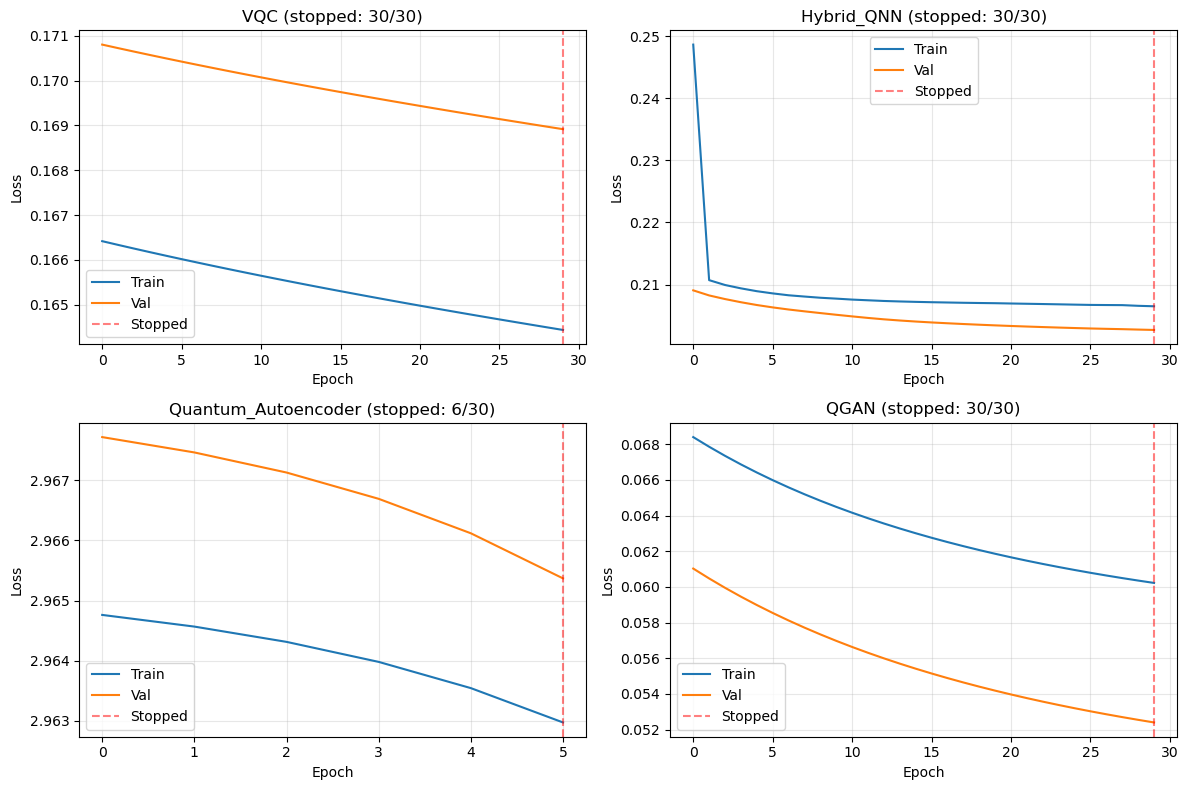

In [14]:
# Training curves (Train vs Val)
fig, axes = plt.subplots(2, 2, figsize=(12, 8))
axes = axes.flatten()

for i, (name, history) in enumerate(all_histories.items()):
    ax = axes[i]
    ax.plot(history['train'], label='Train')
    ax.plot(history['val'], label='Val')
    meta = epoch_metadata[name]
    if meta['stopped_epoch']:
        ax.axvline(x=meta['stopped_epoch']-1, color='r', linestyle='--', alpha=0.5, label='Stopped')
    ax.set_xlabel('Epoch')
    ax.set_ylabel('Loss')
    stopped = meta['stopped_epoch'] or meta['max_epochs']
    ax.set_title(f"{name} (stopped: {stopped}/{meta['max_epochs']})")
    ax.legend()
    ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(FIGURES_DIR / 'qml_training_curves.png', dpi=150)
plt.show()

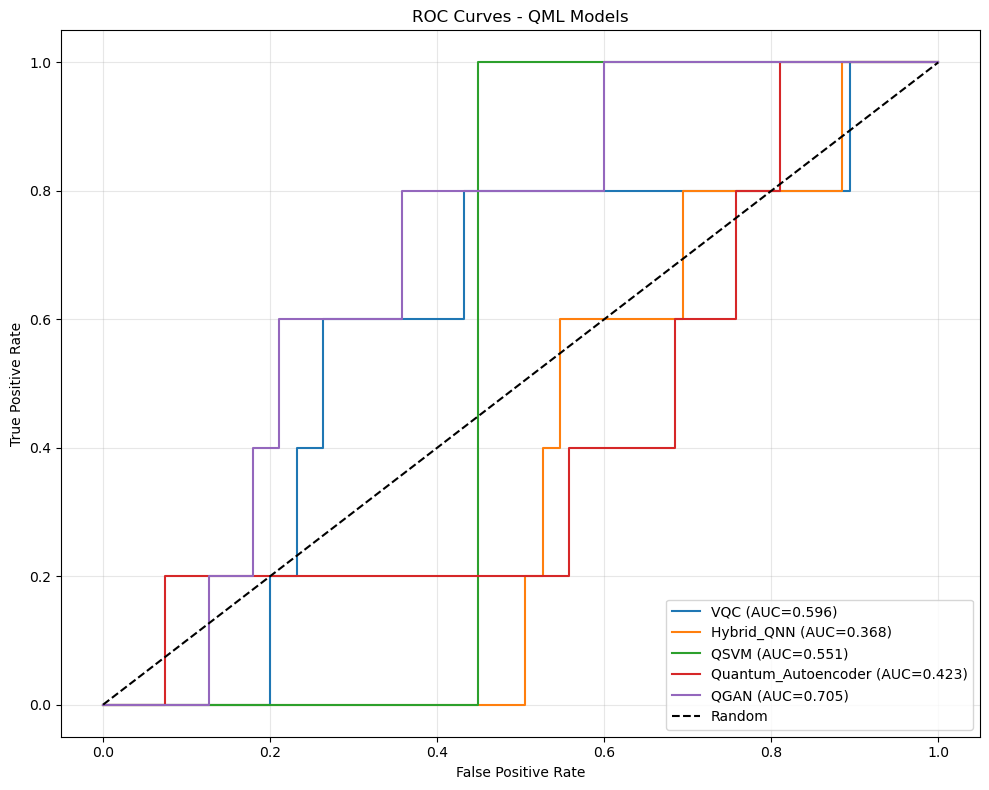

In [15]:
# ROC Curves
plt.figure(figsize=(10, 8))

test_labels = {
    'VQC': y_test_qml, 'Hybrid_QNN': y_test_qml, 'QSVM': y_test_qsvm,
    'Quantum_Autoencoder': y_test_qml, 'QGAN': y_test_qml
}

for model_name, y_prob in all_probabilities.items():
    if y_prob is not None and not np.any(np.isnan(y_prob)):
        try:
            y_true = test_labels[model_name]
            fpr_vals, tpr_vals, _ = roc_curve(y_true, y_prob)
            auc_val = metrics_df[metrics_df['model'] == model_name]['roc_auc'].values[0]
            plt.plot(fpr_vals, tpr_vals, label=f'{model_name} (AUC={auc_val:.3f})')
        except:
            pass

plt.plot([0, 1], [0, 1], 'k--', label='Random')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves - QML Models')
plt.legend(loc='lower right')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig(FIGURES_DIR / 'roc_curves_qml.png', dpi=150)
plt.show()

In [16]:
print("\n" + "="*60)
print("QML MODELS SUMMARY (With Early Stopping)")
print("="*60)
print(f"Total models: {len(all_metrics)}")
print(f"\nBest by F1: {metrics_df.loc[metrics_df['f1_score'].idxmax(), 'model']} ({metrics_df['f1_score'].max():.4f})")
print(f"Best by AUC: {metrics_df.loc[metrics_df['roc_auc'].idxmax(), 'model']} ({metrics_df['roc_auc'].max():.4f})")
print("\nEpoch Summary:")
for name, meta in epoch_metadata.items():
    if meta['stopped_epoch']:
        print(f"  {name}: {meta['stopped_epoch']}/{meta['max_epochs']} (patience={meta['patience']})")
    else:
        print(f"  {name}: N/A (kernel-based)")
print("\n✅ Notebook 8 Complete!")


QML MODELS SUMMARY (With Early Stopping)
Total models: 5

Best by F1: VQC (0.0952)
Best by AUC: QGAN (0.7053)

Epoch Summary:
  VQC: 30/30 (patience=5)
  Hybrid_QNN: 30/30 (patience=5)
  QSVM: N/A (kernel-based)
  Quantum_Autoencoder: 6/30 (patience=5)
  QGAN: 30/30 (patience=5)

✅ Notebook 8 Complete!
